<a href="https://colab.research.google.com/github/dishaanil04/Smart-Solar/blob/main/solar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy pandas scikit-learn matplotlib joblib

In [2]:
# Install dependencies (Colab) - run this first
!pip install --quiet numpy pandas scikit-learn matplotlib joblib


Imports & setup

In [3]:
# Imports and settings
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import joblib, os
from datetime import datetime
np.random.seed(42)

# Create output folder
OUTDIR = 'capstone_outputs'
os.makedirs(OUTDIR, exist_ok=True)


Generate synthetic dataset

In [4]:
timestamps = pd.date_range(datetime(2025,7,1), periods=200, freq='15T')
irr = np.clip(np.linspace(0,800,200) + np.random.normal(0,30,200), 0, None)
power = irr * 0.15 + np.random.normal(0,10,200)
df = pd.DataFrame({
    'timestamp': timestamps,
    'site_id': 'S1',
    'inverter_id': 'S1_INV1',
    'irradiance_w_m2': irr,
    'pv_power_kw': power
})
df['performance_ratio'] = df['pv_power_kw'] / (df['irradiance_w_m2'] / 1000 + 1e-6)
print('Dataset created — rows:', len(df))
df.head()


Dataset created — rows: 200


/tmp/ipython-input-1331925502.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  timestamps = pd.date_range(datetime(2025,7,1), periods=200, freq='15T')


,timestamp,site_id,inverter_id,irradiance_w_m2,pv_power_kw,performance_ratio
0,2025-07-01 00:00:00,S1,S1_INV1,14.901425,5.813087,3.900766e+02
1,2025-07-01 00:15:00,S1,S1_INV1,0.000000,5.607845,5.607845e+06
2,2025-07-01 00:30:00,S1,S1_INV1,27.470857,14.951141,5.442348e+02
3,2025-07-01 00:45:00,S1,S1_INV1,57.751197,19.200700,3.324670e+02
4,2025-07-01 01:00:00,S1,S1_INV1,9.055801,-12.418324,-1.371160e+03


Pre-processing and features

In [5]:
# Minimal preprocessing (already clean synthetic data)
df = df.sort_values('timestamp').reset_index(drop=True)
# Add rolling features
df['pv_power_roll_mean_3h'] = df['pv_power_kw'].rolling(window=12, min_periods=1).mean()
df['pv_power_roll_std_6h'] = df['pv_power_kw'].rolling(window=24, min_periods=1).std()
df['irradiance_roll_mean_3h'] = df['irradiance_w_m2'].rolling(window=12, min_periods=1).mean()
df['temp_diff'] = 0.0  # placeholder since module_temp not present in this simple dataset
df.to_csv(os.path.join(OUTDIR, 'pv_telemetry_processed.csv'), index=False)
print('Preprocessing done — saved processed CSV to', os.path.join(OUTDIR, 'pv_telemetry_processed.csv'))


Preprocessing done — saved processed CSV to capstone_outputs/pv_telemetry_processed.csv


Anomaly detection (Isolation Forest)

In [6]:
anom_features = ['irradiance_w_m2', 'pv_power_kw', 'performance_ratio']
X = df[anom_features].fillna(0).values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
iso = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
iso.fit(X_scaled)
df['anomaly_score'] = -iso.decision_function(X_scaled)
df['anomaly_flag'] = (df['anomaly_score'] > np.percentile(df['anomaly_score'], 95)).astype(int)
joblib.dump(iso, os.path.join(OUTDIR, 'isolation_forest.joblib'))
joblib.dump(scaler, os.path.join(OUTDIR, 'scaler_isolation.joblib'))
print('Anomaly detector trained and saved to', OUTDIR)


Anomaly detector trained and saved to capstone_outputs


Supervised classification (Random Forest)

In [7]:
# Create synthetic maintenance labels from anomaly flags
df['maintenance_label'] = (df['anomaly_flag'] & (np.random.rand(len(df)) > 0.5)).astype(int)

clf_features = anom_features + ['pv_power_roll_mean_3h', 'pv_power_roll_std_6h', 'irradiance_roll_mean_3h']
Xc = df[clf_features].fillna(0).values
scaler_clf = StandardScaler(); Xc_scaled = scaler_clf.fit_transform(Xc)
if df['maintenance_label'].nunique() < 2:
    print('Not enough classes for supervised training — skipping classifier training')
else:
    X_train, X_test, y_train, y_test = train_test_split(Xc_scaled, df['maintenance_label'], test_size=0.3, random_state=42, stratify=df['maintenance_label'])
    clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:,1]
    print('Classification report:')
    print(classification_report(y_test, y_pred))
    try:
        print('ROC AUC:', roc_auc_score(y_test, y_proba))
    except Exception:
        pass
    joblib.dump(clf, os.path.join(OUTDIR, 'rf_classifier.joblib'))
    joblib.dump(scaler_clf, os.path.join(OUTDIR, 'scaler_clf.joblib'))


Classification report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        58
           1       1.00      0.50      0.67         2

    accuracy                           0.98        60
   macro avg       0.99      0.75      0.83        60
weighted avg       0.98      0.98      0.98        60

ROC AUC: 0.9482758620689655


Visualizations

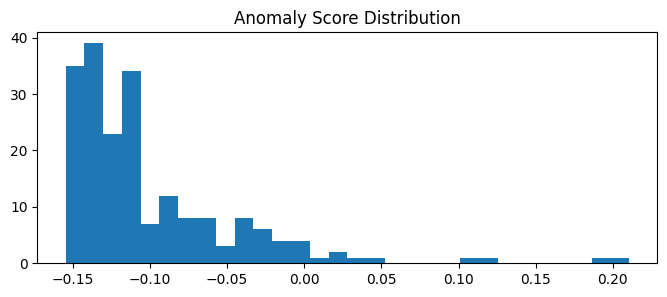

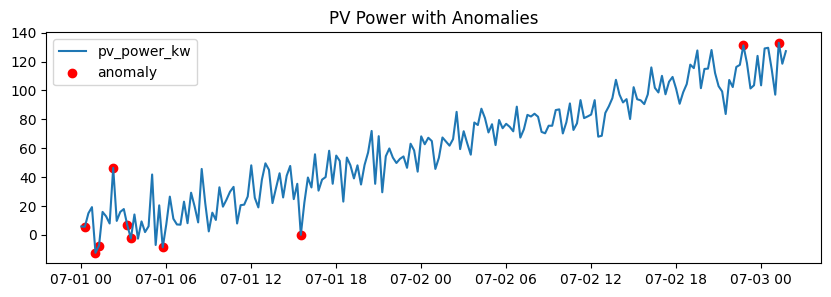

Plots saved to capstone_outputs


In [8]:
plt.figure(figsize=(8,3))
plt.hist(df['anomaly_score'], bins=30)
plt.title('Anomaly Score Distribution')
plt.show()

plt.figure(figsize=(10,3))
plt.plot(df['timestamp'], df['pv_power_kw'], label='pv_power_kw')
plt.scatter(df.loc[df['anomaly_flag']==1,'timestamp'], df.loc[df['anomaly_flag']==1,'pv_power_kw'], c='r', label='anomaly')
plt.legend(); plt.title('PV Power with Anomalies'); plt.show()

# Save plots
plt.figure(); plt.hist(df['anomaly_score'], bins=30); plt.title('Anomaly Score Distribution'); plt.savefig(os.path.join(OUTDIR,'anomaly_score_hist.png')); plt.close()
plt.figure(); plt.plot(df['timestamp'], df['pv_power_kw']); plt.scatter(df.loc[df['anomaly_flag']==1,'timestamp'], df.loc[df['anomaly_flag']==1,'pv_power_kw'], c='r'); plt.title('PV Power with Anomalies'); plt.savefig(os.path.join(OUTDIR,'sample_timeseries_anoms.png')); plt.close()
print('Plots saved to', OUTDIR)


Save artifacts & download

In [9]:
# Save processed dataframe
df.to_csv(os.path.join(OUTDIR, 'pv_telemetry_processed.csv'), index=False)

# Create a zip and provide code to download in Colab
import shutil
zip_name = 'capstone_outputs.zip'
shutil.make_archive('capstone_outputs', 'zip', OUTDIR)
print('Created', zip_name)

# If running in Colab, the following will download the zip automatically. Uncomment when in Colab.
try:
    from google.colab import files
    files.download(zip_name)
except Exception:
    print('Not running in Colab or files.download unavailable. You can download', zip_name, 'from the notebook workspace or /content.')

Created capstone_outputs.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>